## Part2: reproducing the experiments

In this part of the notebook we show how the results presented in the paper can be reproduced.

Note that obtaining the full results can take a while. We also indicate below how partial or full results can be pre-loaded.

Finally note that if you get warning boxes, this is because of external dependencies (in particular `Klara.jl`), have a look at the `README.md` if you would like to avoid seeing such warning boxes.

# PDSampler experiments

### Defining the model

(see `*-demo.ipynb` for more explanations on this part)

In [1]:
using PDSampler

In [2]:
srand(1777)

n, p = 10000, 20

ξ = rand(n, p)  # feature matrix
β = rand(p)     # ground truth 

# Generate labels on {-1,+1}
y = (PDSampler.logistic.(ξ * β) .> rand(n))
y = y * 2 - 1

# proxy for the N*L upper bound
b = sum( mapslices(ξi->norm(ξi)^2, ξ, 1) )/4

;

### Redefining loglik + gradloglik to add counter

In order to compare PDSampler and HMC, we want to be able to have a fair measure of computational burden. Here we look at the number of time a data point is considered.

- computation of a full likelihood : $n$ data points considered
- computation of a full gradient : $n$ data points considered
- computation of a CV gradient : $1$ data point considered (could be more than one but we consider the case with a single data point here)

Below we re-define the functions computing the loglikelihood and gradient accordingly.

In [3]:
global num_data_evals = 0

function init_tracker()
    global num_data_evals
    num_data_evals = 0
end

function inc_tracker(k=1)
    global num_data_evals
    num_data_evals += k
end

# ==============================
log1pexp(x::Float) = x < 18.0 ? log1p(exp(x)) : x < 33.3 ? x + exp(-x) : x

logistic(x::Float)        =  1.0 / (1.0 + exp(-x))
loglogistic(x::Float)     = -log1pexp(-x)
gradloglogistic(x::Float) =  logistic(-x)

function loglik(lr::LogReg, w::Vector{Float})::Float
    sum( loglogistic.(lr.y .* (lr.X*w)) )
    inc_tracker(lr.n) # evaluation over n data points
end

glli(w, lr, i) = gradloglogistic(lr.y[i]*(dot(lr.X[i,:],w)))

function gradloglik(lr::LogReg, w::Vector{Float})::Vector{Float}
    inc_tracker(lr.n) # evaluation over n data points
    sum( lr.y[i]* glli(w,lr,i) * lr.X[i,:]  for i in 1:lr.n)
end

function gradloglik_cv(lr::LogReg, wstar::Vector{Float})::Function
    # Unbiased estimate of \nabla U_j(x) using control variates
    gll_star = gradloglik(lr, wstar)
    function gll_cv(w::Vector{Float}, i=rand(1:lr.n))::Vector{Float}
        inc_tracker()
        tw, tws = glli(w,lr,i), glli(wstar,lr,i)
        # unbiased estimate of the gradient
        gll_star + lr.n*lr.y[i] * (tw*lr.X[i,:]-tws*lr.X[i,:])
    end
end
;

Now we can define the Data model as we did before except that we use our tracked likelibood etc.

In [4]:
# Declare the Data Model
dm = PDSampler.LogReg(ξ, y, b)
;

# Declare the geometry
ns, a = eye(p), zeros(p)
geom  = PDSampler.Polygonal(ns, a)

# The geometry defines the 'nextboundary' along a ray
nextboundary(x, v) = PDSampler.nextboundary(geom, x, v)

# Gradients and sampling of IPP
gll_cv       = gradloglik_cv(dm, β)
gll_star     = gradloglik(dm, β)
linear_bound = PDSampler.LinearBound(β, gll_star, dm.b)

# define how to compute the next event along a ray
nextevent(x, v) = PDSampler.nextevent_bps(linear_bound, x, v)
;

## PDSampler experiments

For each experiment, we want to output

* the path (so that the ESS and RMSE can be computed a posteriori)
* the simulation details (just in case we care to look into some of those)
* number of data evaluations (for the comparison) 

In [5]:
maxgradeval = [10, 50, 100, 500, 1000]*10000
n_exp = 10

T     = Inf   
λ_ref = 2.

exp_paths   = Array{Path}(length(maxgradeval), n_exp)
exp_details = Array{Dict}(length(maxgradeval), n_exp)
exp_evals   = Array{Int}(length(maxgradeval), n_exp)

for (i, mg) in enumerate(maxgradeval)
    # print some info to get an idea of what is done
    print("Max Grad Eval: $mg ")

    for experiment = 1:n_exp      
        # re-initialise tracker
        init_tracker()

        x0  = rand(dm.p)
        v0  = randn(dm.p)
        v0 /= norm(v0)

        sim = PDSampler.Simulation(x0, v0, T, nextevent,
                              gll_cv, nextboundary, λ_ref;
                              maxgradeval = mg)

        (path, details) = PDSampler.simulate(sim)

        # save results for later exploration
        exp_paths[i, experiment]   = path
        exp_details[i, experiment] = details
        exp_evals[i, experiment]   = num_data_evals

        # print some info to get an idea of what is done
        print("$experiment ")
    end
    print("\n")
end
;

Max Grad Eval: 100000 1 2 3 4 5 6 7 8 9 10 
Max Grad Eval: 500000 1 2 3 4 5 6 7 8 9 10 
Max Grad Eval: 1000000 1 2 3 4 5 6 7 8 9 10 
Max Grad Eval: 5000000 1 2 3 4 5 6 7 8 9 10 
Max Grad Eval: 10000000 1 2 3 4 5 6 7 8 9 10 


## Short analysis of the results of the PDSampler experiments

Here we show how to get some interesting properties out of what was saved in particular

* the average ESS across dimension
* the RMSE

In [16]:
# Generate seeded test data
srand(54230)

nt = 500
ξt = rand(nt, size(ξ)[2])
yt = (PDSampler.logistic.(ξt * β) .> rand(nt))
yt = yt * 2 - 1

avgESS    = zeros(size(exp_evals))
rmse      = zeros(size(exp_evals))
rmse_test = zeros(size(exp_evals))

for i = 1:size(exp_evals)[1]
    for j = 1:size(exp_evals)[2]
        
        path = exp_paths[i, j]
        
        wmean  = pathmean(path)
        ypred  = PDSampler.logistic.(ξ * wmean) * 2 - 1
        ypredt = PDSampler.logistic.(ξt * wmean) * 2 -1
        
        rmse[i, j]      = sqrt(sum((ypred-y).^2)/length(y))
        rmse_test[i, j] = sqrt(sum((ypredt-yt).^2)/length(yt))
        avgESS[i, j]    = mean(esspath(path)[1])
    end
end

epochs = exp_evals/size(ξ)[1]
;

# HMC experiments with Klara

Note: the first part is duplicated, this is so that this part of the notebook can be ran independently of the top part.

In [7]:
import Klara

### Declaring the model

This is very similar as for the PDSampler (and in fact uses some of the PDSampler architecture for it) but note the way the log likelihood is defined.

In [8]:
srand(1777)

n, p = 10000, 20

ξ = rand(n, p)  # feature matrix
β = rand(p)     # ground truth 

# Generate labels on {-1,+1}
y = (PDSampler.logistic.(ξ * β) .> rand(n))
y = y * 2 - 1

# proxy for the N*L upper bound
b = sum( mapslices(ξi->norm(ξi)^2, ξ, 1) )/4

# Declare the Data Model
dm = PDSampler.LogReg(ξ, y, b)

# Loglikelihood on orthant and gradient of log-likelihood (CV)
loglik(β)     = (any(β.<0)) ? -Inf : loglik(dm, β)
gradloglik(β) = gradloglik(dm, β);

### Running the experiments

In [9]:
# Continuous Multivariate Parameter
p = Klara.BasicContMuvParameter( :p, 
                logtarget = loglik,
                gradlogtarget = gradloglik )
model = Klara.likelihood_model(p, false)

# HMC with 5 leapfrog steps
nleapf  = 5
sampler = Klara.HMC(0.01, nleapf)

n_steps       = [50, 100, 150, 200, 250]
n_exp         = 10 #10
avg_ess_hmc   = zeros(length(n_steps), n_exp)
num_evals_hmc = zeros(length(n_steps), n_exp)

exp_chains = Array{Array{Float64}}(length(n_steps), n_exp)
exp_evals  = Array{Int}(length(n_steps), n_exp)

for i in 1:length(n_steps)
    print("Running HMC for: $(n_steps[i]) steps: ")
    for experiment = 1:n_exp        
        
        init_tracker()
        
        # Initial point
        x0 = rand(dm.p)
        
        mcrange = Klara.BasicMCRange(
                          nsteps = n_steps[i], 
                          burnin = 1)

        # what do we want out?
        outopts = Dict{Symbol, Any}( 
                     :diagnostics=>[:accept])

        job = Klara.BasicMCJob(model, sampler, mcrange, 
                                Dict(:p=>x0), outopts = outopts);

        Klara.run(job)
        exp_chains[i, experiment] = Klara.output(job).value
        exp_evals[i, experiment]  = num_data_evals
        
        print("$experiment ")
    end
    print("\n")
end


Running HMC for: 50 steps: 1 2 3 4 5 6 7 8 9 10 
Running HMC for: 100 steps: 1 2 3 4 5 6 7 8 9 10 
Running HMC for: 150 steps: 1 2 3 4 5 6 7 8 9 10 
Running HMC for: 200 steps: 1 2 3 4 5 6 7 8 9 10 
Running HMC for: 250 steps: 1 2 3 4 5 6 7 8 9 10 


## Short analysis of the HMC results

In [10]:
# Generate seeded test data
srand(54230)

nt = 500
ξt = rand(nt, size(ξ)[2])
yt = (PDSampler.logistic.(ξt * β) .> rand(nt))
yt = yt * 2 - 1

avgESS_hmc    = zeros(size(exp_evals))
rmse_hmc      = zeros(size(exp_evals))
rmse_hmc_test = zeros(size(exp_evals))

for i = 1:size(exp_evals)[1]
    for j = 1:size(exp_evals)[2]
        
        chainvals = exp_chains[i, j]
        
        wmean  = mean(chainvals,2)
        ypred  = PDSampler.logistic.(ξ * wmean) * 2 - 1
        ypredt = PDSampler.logistic.(ξt * wmean) * 2 - 1
        
        rmse_hmc[i, j]      = sqrt(sum((ypred-y).^2)/length(y))
        rmse_hmc_test[i, j] = sqrt(sum((ypredt-yt).^2)/length(yt))
        avgESS_hmc[i, j]    = mean([Klara.ess(exp_chains[i, j][k, :]) for k in 1:length(β)])
    end
end

epochs_hmc = exp_evals/size(ξ)[1]
;

# General analysis

## Boxplots PDSampler cv

In [11]:
using PyPlot

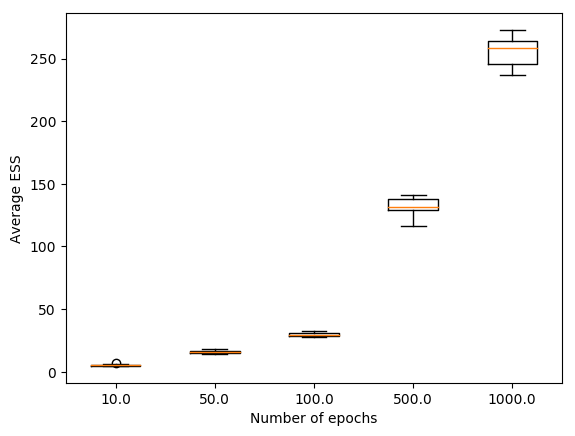

In [19]:
PyPlot.figure()
PyPlot.boxplot(avgESS')
PyPlot.xticks(1:length(epochs[:,1]), maxgradeval/n)
PyPlot.ylabel("Average ESS")
PyPlot.xlabel("Number of epochs")
;

## Boxplot HMC

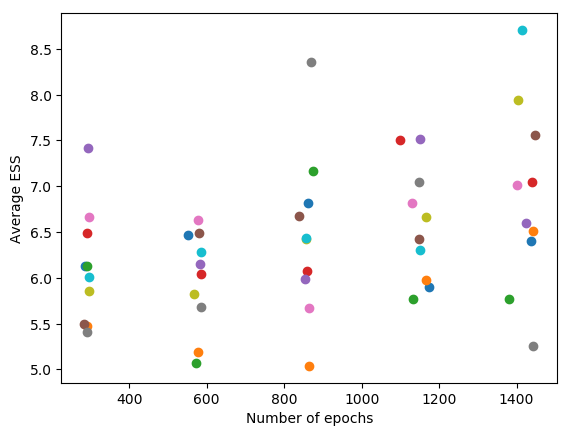

In [13]:
PyPlot.figure()

PyPlot.plot(epochs_hmc, avgESS_hmc, ls="none", marker="o")
PyPlot.ylabel("Average ESS")
PyPlot.xlabel("Number of epochs")
;

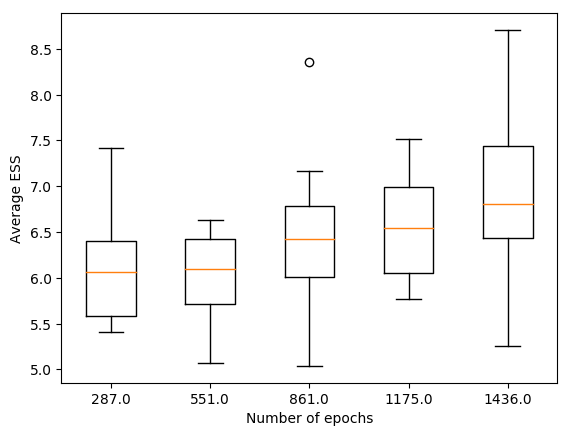

In [14]:
PyPlot.figure()
PyPlot.boxplot(avgESS_hmc')
PyPlot.xticks(1:length(epochs_hmc[:,1]), epochs_hmc[:,1])
PyPlot.ylabel("Average ESS")
PyPlot.xlabel("Number of epochs")
;